Capstone Project -- Battle of Neighbourhoods

Finding a Better Place to Move in Toronto, Canada

In [ ]:
by: Ajay Mutreja, April 2020

In [6]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install html5lib

Note: you may need to restart the kernel to use updated packages.


In [8]:
pip install lxml

     |████████████████████████████████| 5.8MB 19.0MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [9]:
pip install BeautifulSoup4

     |████████████████████████████████| 112kB 8.1MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [10]:
pip install folium

Note: you may need to restart the kernel to use updated packages.


In [11]:
pip install geopy

     |████████████████████████████████| 112kB 25.9MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [12]:
import pandas as pd
import requests
import numpy as np

import folium
import requests 
import matplotlib.cm as cm
import matplotlib.colors as colors
import json
import xml
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
from pandas.io.html import read_html
from bs4 import BeautifulSoup
from pandas.io.json import json_normalize 
from sklearn.cluster import KMeans
from geopy.geocoders import Nominatim 

print("All Required Libraries Imported!")

All Required Libraries Imported!


Data Extraction and Cleaning

In [13]:
#1. Extract Data from Wikipedia page
website = "https://en.wikipedia.org/w/index.php?title=List_of_postal_codes_of_Canada:_M&oldid=945633050"
url_text = requests.get(website).text
soup = BeautifulSoup(url_text, 'html.parser')
print(soup.title)
#soup.prettify()
data=soup.find('table', attrs={'class':'wikitable sortable'})
#print(data)
print('Data_Ready')

<title>List of postal codes of Canada: M - Wikipedia</title>
Data_Ready


In [14]:
# 2 Create DataFrame
column_names = ['Postalcode','Borough','Neighborhood']
toronto_df = pd.DataFrame(columns = column_names)
toronto_df.head()

,Postalcode,Borough,Neighborhood


In [15]:
#3 Create Table
table = data.tbody
print('Table_Ready')
#print(table)

Table_Ready


In [16]:
#3 Insert Table to Dataframe
postcode=0
borough=0
neighborhood=0
for tr in table.find_all('tr'):
    i = 0
    for td in tr.find_all('td'):
        if i == 0:
            postcode = td.text
            i = i + 1
        elif i == 1:
            borough = td.text
            i = i + 1
        elif i == 2: 
            neighborhood = td.text.strip('\n').replace(']','')
    toronto_df = toronto_df.append({'Postalcode': postcode,'Borough': borough,'Neighborhood': neighborhood},ignore_index=True)
toronto_df.head()

,Postalcode,Borough,Neighborhood
0,0,0,0
1,M1A,Not assigned,Not assigned
2,M2A,Not assigned,Not assigned
3,M3A,North York,Parkwoods
4,M4A,North York,Victoria Village


In [17]:
# 4 clean dataframe 
toronto_df = toronto_df[toronto_df.Borough!='Not assigned']
toronto_df = toronto_df[toronto_df.Borough!= 0]
toronto_df.reset_index(drop = True, inplace = True)
i = 0
for i in range(0,toronto_df.shape[0]):
    if toronto_df.iloc[i][2] == 'Not assigned':
        toronto_df.iloc[i][2] = toronto.iloc[i][1]
        i = i+1
        
df = toronto_df.groupby(['Postalcode','Borough'])['Neighborhood'].apply(', '.join).reset_index()
#df.describe()
#df.head()
#df

In [18]:
df = df.dropna()
empty = 'Not assigned'
df = df[(df.Postalcode != empty ) & (df.Borough != empty) & (df.Neighborhood != empty)]
#df.head()

In [19]:
# 5 Index Dataframe by Neighborhood
def neighborhood_list(grouped):    
    return ', '.join(sorted(grouped['Neighborhood'].tolist()))
                    
grp = df.groupby(['Postalcode', 'Borough'])
df_2 = grp.apply(neighborhood_list).reset_index(name='Neighborhood')
print(df_2.shape)
df_2.head(62)

(103, 3)


,Postalcode,Borough,Neighborhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae
...,...,...,...
57,M5G,Downtown Toronto,Central Bay Street
58,M5H,Downtown Toronto,"Adelaide, King, Richmond"
59,M5J,Downtown Toronto,"Harbourfront East, Toronto Islands, Union Station"
60,M5K,Downtown Toronto,"Design Exchange, Toronto Dominion Centre"


In [20]:
pip install geocoder

     |████████████████████████████████| 102kB 3.2MB/s ta 0:00:011
     |████████████████████████████████| 829kB 8.1MB/s eta 0:00:01
     |████████████████████████████████| 92kB 22.8MB/s eta 0:00:01
  Stored in directory: /home/jupyterlab/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
Successfully built future
Note: you may need to restart the kernel to use updated packages.


In [21]:
import geocoder

In [22]:
# To_City Coordinates, with postal code selection

def get_latilong(postal_code):
    lati_long_coords = None
    while(lati_long_coords is None):
        g = geocoder.arcgis('{}, Toronto, Ontario'.format(postal_code))
        lati_long_coords = g.latlng
    return lati_long_coords
# Postal Code of Downtown Toronto = M5G
get_latilong('M5G') # Give Drop Down Selction option to enable input To_City

[43.65607218800005, -79.38565318999997]

In [23]:
# Getting Coordinates fo all Toronto Postal Codes
postal_codes = df_2['Postalcode']    
coords = [ get_latilong(postal_code) for postal_code in postal_codes.tolist() ]

In [24]:
# Adding Columns Latitude & Longitude
df_coords = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])
df_2['Latitude'] = df_coords['Latitude']
df_2['Longitude'] = df_coords['Longitude']
# Verify Addtion
df_2[df_2.Postalcode=='M5G']

,Postalcode,Borough,Neighborhood,Latitude,Longitude
57,M5G,Downtown Toronto,Central Bay Street,43.656072,-79.385653


In [93]:
#Get The Coordinates for From City
From_city = 'Mumbai, India' # Customers to Input
geolocator = Nominatim()
location = geolocator.geocode(From_city)
latitude_x = location.latitude
longitude_y = location.longitude
print('The Geograpical Co-ordinate of From_city are {}, {}.'.format(latitude_x, longitude_y))

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Using Nominatim with the default "geopy/1.21.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  This is separate from the ipykernel package so we can avoid doing imports until


The Geograpical Co-ordinate of From_city are 18.9387711, 72.8353355.


In [98]:
#Get The Coordinates for From City
To_city = 'Downtown Toronto' # Flow Input from 
geolocator = Nominatim()
location = geolocator.geocode(To_city)
latitude_d_x = location.latitude
longitude_d_y = location.longitude
print('The Geograpical Co-ordinate of To_city are {}, {}.'.format(latitude_d_x, longitude_d_y))

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Using Nominatim with the default "geopy/1.21.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  This is separate from the ipykernel package so we can avoid doing imports until


The Geograpical Co-ordinate of To_city are 43.6541737, -79.38081164513409.


In [100]:
# MAP of To_City

map_dt = folium.Map(location=[latitude_d_x, longitude_d_y], zoom_start=10)

for lat, lng, nei in zip(df_2['Latitude'], df_2['Longitude'], df_2['Neighborhood']):
    
    label = '{}'.format(nei)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_dt)  
    
print('Map_Downtown_toronto')
map_dt

Map_Downtown_toronto


In [54]:
# My Foursquare Data

CLIENT_ID = '3F3YDN2VQZUADF5V11FJMWFBCDKGJICMVFZ05IXLMDYMARQX' # My Foursquare ID
CLIENT_SECRET = 'YARHBTR521ACZH0BSXQUVJY0TJXDX2U135SENELE4VD1QKCQ' # My Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('My Credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

My Credentails:
CLIENT_ID: 3F3YDN2VQZUADF5V11FJMWFBCDKGJICMVFZ05IXLMDYMARQX
CLIENT_SECRET:YARHBTR521ACZH0BSXQUVJY0TJXDX2U135SENELE4VD1QKCQ


In [101]:
radius = 100 
LIMIT = 100
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude_x, 
    longitude_y, 
    radius, 
   LIMIT)
results = requests.get(url).json()

In [102]:
venues=results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues)
nearby_venues.columns

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  


Index(['referralId', 'reasons.count', 'reasons.items', 'venue.id',
       'venue.name', 'venue.location.address', 'venue.location.crossStreet',
       'venue.location.lat', 'venue.location.lng',
       'venue.location.labeledLatLngs', 'venue.location.distance',
       'venue.location.postalCode', 'venue.location.cc', 'venue.location.city',
       'venue.location.state', 'venue.location.country',
       'venue.location.formattedAddress', 'venue.categories',
       'venue.photos.count', 'venue.photos.groups',
       'venue.location.neighborhood', 'venue.venuePage.id'],
      dtype='object')

In [103]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [104]:
# Nearby Venue Locations
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]
nearby_venues.head()

,venue.name,venue.categories,venue.location.lat,venue.location.lng
0,LUSH,"[{'id': '4bf58dd8d48988d10c951735', 'name': 'C...",43.653557,-79.380400
1,Indigo,"[{'id': '4bf58dd8d48988d114951735', 'name': 'B...",43.653515,-79.380696
2,CF Toronto Eaton Centre,"[{'id': '4bf58dd8d48988d1fd941735', 'name': 'S...",43.654540,-79.380677
3,SEPHORA,"[{'id': '4bf58dd8d48988d10c951735', 'name': 'C...",43.653688,-79.380120
4,Nordstrom,"[{'id': '4bf58dd8d48988d103951735', 'name': 'C...",43.655041,-79.380966


In [105]:
# Categories of Nearby Venue/Locations
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head(10)

,name,categories,lat,lng
0,LUSH,Cosmetics Shop,43.653557,-79.380400
1,Indigo,Bookstore,43.653515,-79.380696
2,CF Toronto Eaton Centre,Shopping Mall,43.654540,-79.380677
3,SEPHORA,Cosmetics Shop,43.653688,-79.380120
4,Nordstrom,Clothing Store,43.655041,-79.380966
5,Danish Pastry House,Bakery,43.654574,-79.380740
6,Apple Eaton Centre,Electronics Store,43.654064,-79.380697
7,Crepe Delicious,Fast Food Restaurant,43.654536,-79.380889
8,Magic Tailor,Clothing Store,43.653742,-79.379745
9,Roots,Clothing Store,43.653613,-79.380244


In [106]:
# Top 10 Categories
a=pd.Series(nearby_venues.categories)
a.value_counts()[:10]

Clothing Store          5
Cosmetics Shop          3
Fast Food Restaurant    1
Electronics Store       1
Shoe Store              1
Bakery                  1
Shopping Mall           1
Tanning Salon           1
Italian Restaurant      1
Lingerie Store          1
Name: categories, dtype: int64

In [107]:

def getNearbyVenues(names, latitudes, longitudes, radius=700):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # making GET request
        venue_results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in venue_results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [108]:
# Nearby Downtown Toronto
dt_venues = getNearbyVenues(names=df_2['Neighborhood'],
                                   latitudes=df_2['Latitude'],
                                   longitudes=df_2['Longitude']
                                  )

Rouge, Malvern
Highland Creek, Rouge Hill, Port Union
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
East Birchmount Park, Ionview, Kennedy Park
Clairlea, Golden Mile, Oakridge
Cliffcrest, Cliffside, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Scarborough Town Centre, Wexford Heights
Maryvale, Wexford
Agincourt
Clarks Corners, Sullivan, Tam O'Shanter
Agincourt North, L'Amoreaux East, Milliken, Steeles East
L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview, Henry Farm, Oriole
Bayview Village
Silver Hills, York Mills
Newtonbrook, Willowdale
Willowdale South
York Mills West
Willowdale West
Parkwoods
Don Mills North
Flemingdon Park, Don Mills South
Bathurst Manor, Downsview North, Wilson Heights
Northwood Park, York University
CFB Toronto, Downsview East
Downsview West
Downsview Central
Downsview Northwest
Victoria Village
Woodbine Gardens, Parkview Hill
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
East Toronto
The Danforth West, 

In [109]:
print('There are {} Uniques Categories.'.format(len(dt_venues['Venue Category'].unique())))
dt_venues.groupby('Neighborhood').count().head()

There are 321 Uniques Categories.


,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Adelaide, King, Richmond",100,100,100,100,100,100
Agincourt,30,30,30,30,30,30
"Agincourt North, L'Amoreaux East, Milliken, Steeles East",3,3,3,3,3,3
"Albion Gardens, Beaumond Heights, Humbergate, Jamestown, Mount Olive, Silverstone, South Steeles, Thistletown",15,15,15,15,15,15
"Alderwood, Long Branch",11,11,11,11,11,11


In [110]:
# one hot encoding

dt_onehot = pd.get_dummies(dt_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
dt_onehot['Neighborhood'] = dt_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [dt_onehot.columns[-1]] + list(dt_onehot.columns[:-1])
dt_onehot = dt_onehot[fixed_columns]
dt_grouped = dt_onehot.groupby('Neighborhood').mean().reset_index()
dt_onehot.head()

,Yoga Studio,Accessories Store,Afghan Restaurant,African Restaurant,Airport,American Restaurant,Antique Shop,Arcade,Art Gallery,Art Museum,...,University,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [111]:
num_top_venues = 10
for hood in dt_grouped['Neighborhood']:
    print("---- "+hood+" ----")
    temp =dt_grouped[dt_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

---- Adelaide, King, Richmond ----
            venue  freq
0     Coffee Shop  0.07
1            Café  0.06
2      Restaurant  0.06
3           Hotel  0.05
4  Clothing Store  0.04
5         Theater  0.04
6       Gastropub  0.03
7          Bakery  0.03
8             Gym  0.03
9             Bar  0.02


---- Agincourt ----
                       venue  freq
0              Shopping Mall  0.10
1         Chinese Restaurant  0.07
2                       Pool  0.03
3   Mediterranean Restaurant  0.03
4                       Bank  0.03
5  Latin American Restaurant  0.03
6        Shanghai Restaurant  0.03
7                       Park  0.03
8            Bubble Tea Shop  0.03
9           Sushi Restaurant  0.03


---- Agincourt North, L'Amoreaux East, Milliken, Steeles East ----
                     venue  freq
0           Sandwich Place  0.33
1              Coffee Shop  0.33
2                 Pharmacy  0.33
3                Nightclub  0.00
4          Organic Grocery  0.00
5             Optical Shop 

In [112]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [113]:
# Most Common Venues Near Neighborhood
import numpy as np
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = dt_grouped['Neighborhood']

for ind in np.arange(dt_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(dt_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Coffee Shop,Restaurant,Café,Hotel,Clothing Store,Theater,Gym,Gastropub,Bakery,Fast Food Restaurant
1,Agincourt,Shopping Mall,Chinese Restaurant,Lounge,Seafood Restaurant,Sushi Restaurant,Supermarket,Latin American Restaurant,Breakfast Spot,Bubble Tea Shop,Malay Restaurant
2,"Agincourt North, L'Amoreaux East, Milliken, St...",Coffee Shop,Pharmacy,Sandwich Place,Women's Store,Falafel Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School
3,"Albion Gardens, Beaumond Heights, Humbergate, ...",Hardware Store,Pharmacy,Japanese Restaurant,Fried Chicken Joint,Grocery Store,Park,Liquor Store,Gym Pool,Caribbean Restaurant,Fast Food Restaurant
4,"Alderwood, Long Branch",Pub,Pharmacy,Gym,Athletics & Sports,Sandwich Place,Skating Rink,Dance Studio,Coffee Shop,Gas Station,Pizza Place


In [114]:
# K Means Clustering Approach
# Using K-Means to cluster neighborhood into 3 clusters

dt_grouped_clustering = dt_grouped.drop('Neighborhood', 1)
kmeans = KMeans(n_clusters=3, random_state=0).fit(dt_grouped_clustering)
kmeans.labels_

array([1, 1, 1, 1, 1, 1, 2, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1,
       1, 2, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0], dtype=int32)

In [115]:
neighborhoods_venues_sorted.insert(0,'cluster_labels' ,kmeans.labels_)

dt_merged = df_2.iloc[:16,:]

# merge dt_grouped with toronto_data to add latitude/longitude for each neighborhood

dt_merged = dt_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

dt_merged.head() # check the last columns!

,Postalcode,Borough,Neighborhood,Latitude,Longitude,cluster_labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Scarborough,"Rouge, Malvern",43.808626,-79.189913,2,Park,Trail,Women's Store,Farm,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Ethiopian Restaurant,Falafel Restaurant
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.785779,-79.157368,0,Bar,History Museum,Fish & Chips Shop,Park,Farm,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.765806,-79.185284,1,Pizza Place,Fast Food Restaurant,Park,Supermarket,Bank,Pharmacy,Coffee Shop,Sandwich Place,Burger Joint,Food & Drink Shop
3,M1G,Scarborough,Woburn,43.771545,-79.218135,1,Coffee Shop,Park,Business Service,Women's Store,Farm,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Ethiopian Restaurant
4,M1H,Scarborough,Cedarbrae,43.768791,-79.238813,1,Gas Station,Athletics & Sports,Bank,Thai Restaurant,Hakka Restaurant,Lounge,Eastern European Restaurant,Electronics Store,Elementary School,Ethiopian Restaurant


In [116]:
kclusters = 7

In [118]:
# create map
map_clusters = folium.Map(location=[latitude_d_x, longitude_d_y], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]
print(rainbow)

['#8000ff', '#2c7ef7', '#2adddd', '#80ffb4', '#d4dd80', '#ff7e41', '#ff0000']


In [119]:
# add markers to the map

markers_colors = []
for lat, lon, nei , cluster in zip(dt_merged['Latitude'], 
                                   dt_merged['Longitude'], 
                                   dt_merged['Neighborhood'], 
                                   dt_merged['cluster_labels']):
    label = folium.Popup(str(nei) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [120]:
df1 = dt_merged.loc[dt_merged['cluster_labels'] == 0,dt_merged.columns[[2] + list(range(5, dt_merged.shape[1]))]]
df2 = dt_merged.loc[dt_merged['cluster_labels'] == 1,dt_merged.columns[[2] + list(range(5, dt_merged.shape[1]))]]
df3 = dt_merged.loc[dt_merged['cluster_labels'] == 2,dt_merged.columns[[2] + list(range(5, dt_merged.shape[1]))]]
print("df's Ready")

df's Ready


In [146]:
dt_Avg_Housing_Price = pd.DataFrame({"Neighborhood":df_2["Neighborhood"],
                                      "Average_Housing_Price":[335000.0,286600.0,175000.0,225900.0,219400.0,
                                                               573900.0,225000.0,370500.0,370500.0,433500.0,279200.0,
                                                               279200.0,225000.0,370500.,255400.0,433500.0,433500.0,
                                                               435000.0,289500.0,265000.0,285900.0,239400.0,
                                                               589900.0,295000.0,380500.0,378500.0,438500.0,229200.0,
                                                               229200.0,365000.0,388500.,285400.0,493500.0,477500.0,378000.0,316600.0,195000.0,225900.0,219400.0,
                                                               573900.0,367000.0,370500.0,370500.0,363500.0,279200.0,
                                                               279200.0,271000.0,370500.,255400.0,383500.0,433500.0,335000.0,286600.0,185000.0,225900.0,219400.0,
                                                               573900.0,329000.0,370500.0,370500.0,533500.0,279200.0,
                                                               279200.0,375000.0,370500.,255400.0,493500.0,433500.0,335000.0,286600.0,165000.0,225900.0,219400.0,
                                                               573900.0,425000.0,370500.0,370500.0,433500.0,279200.0,
                                                               279200.0,195000.0,370500.,255400.0,403500.0,433500.0,335000.0,286600.0,187000.0,225900.0,219400.0,
                                                               573900.0,325000.0,370500.0,370500.0,333500.0,279200.0,
                                                               279200.0,289000.0,370500.,255400.0,413500.0,433500.0,254800.0
                                                              
                                                              
                                                              ]})

In [149]:
dt_Avg_Housing_Price.set_index('Neighborhood',inplace=True,drop=True)

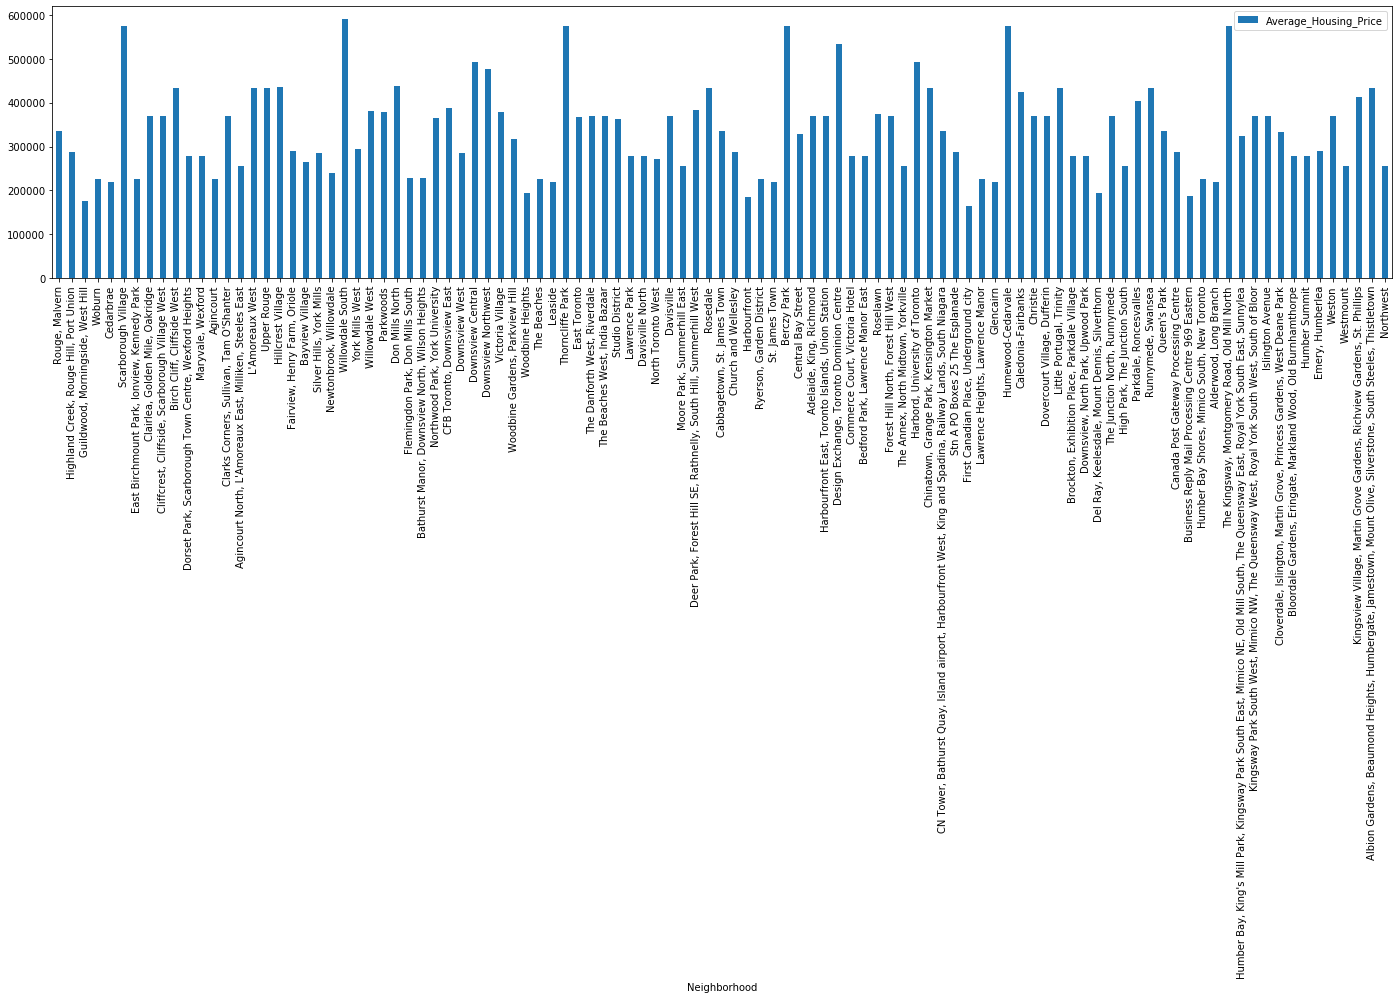

In [159]:
dt_Avg_Housing_Price.plot(kind='bar',figsize=(24,5),alpha=1.0)

In [133]:
#Schools rating Clusters
clusters=pd.DataFrame({"Cluster1":df1["Neighborhood"],
                      "Cluster2":df2["Neighborhood"],
                      "Cluster4":df3["Neighborhood"]})
clusters = clusters.replace(np.nan, '', regex=True)

In [134]:
new_dt = dt_merged.set_index("Neighborhood",drop=True)

#Source:https://www.greatschools.org

dt_school_ratings=pd.DataFrame({"Neighborhood":df["Neighborhood"],
                                      "Top School Rating":[7,9,5,8,10,10,7,10,1,2,1,2,7,2,3,2,6,
                                                           5,4,8,9,9,6,6,4,5,4,6,8,10,8,9,6,2,
                                                           10,2,5,8,9,6,6,10,8,9,1,2,3,4,5,6,9,
                                                           8,5,9,6,9,6,4,8,10,2,5,6,3,9,8,7,
                                                           7,8,5,8,9,1,5,4,7,2,3,6,6,9,4,8,7,
                                                           4,8,9,2,6,4,7,5,10,4,6,8,9,7,5,6,5,8,7
                                                           ]})

In [135]:
dt_school_ratings.set_index('Neighborhood',inplace=True,drop=True)

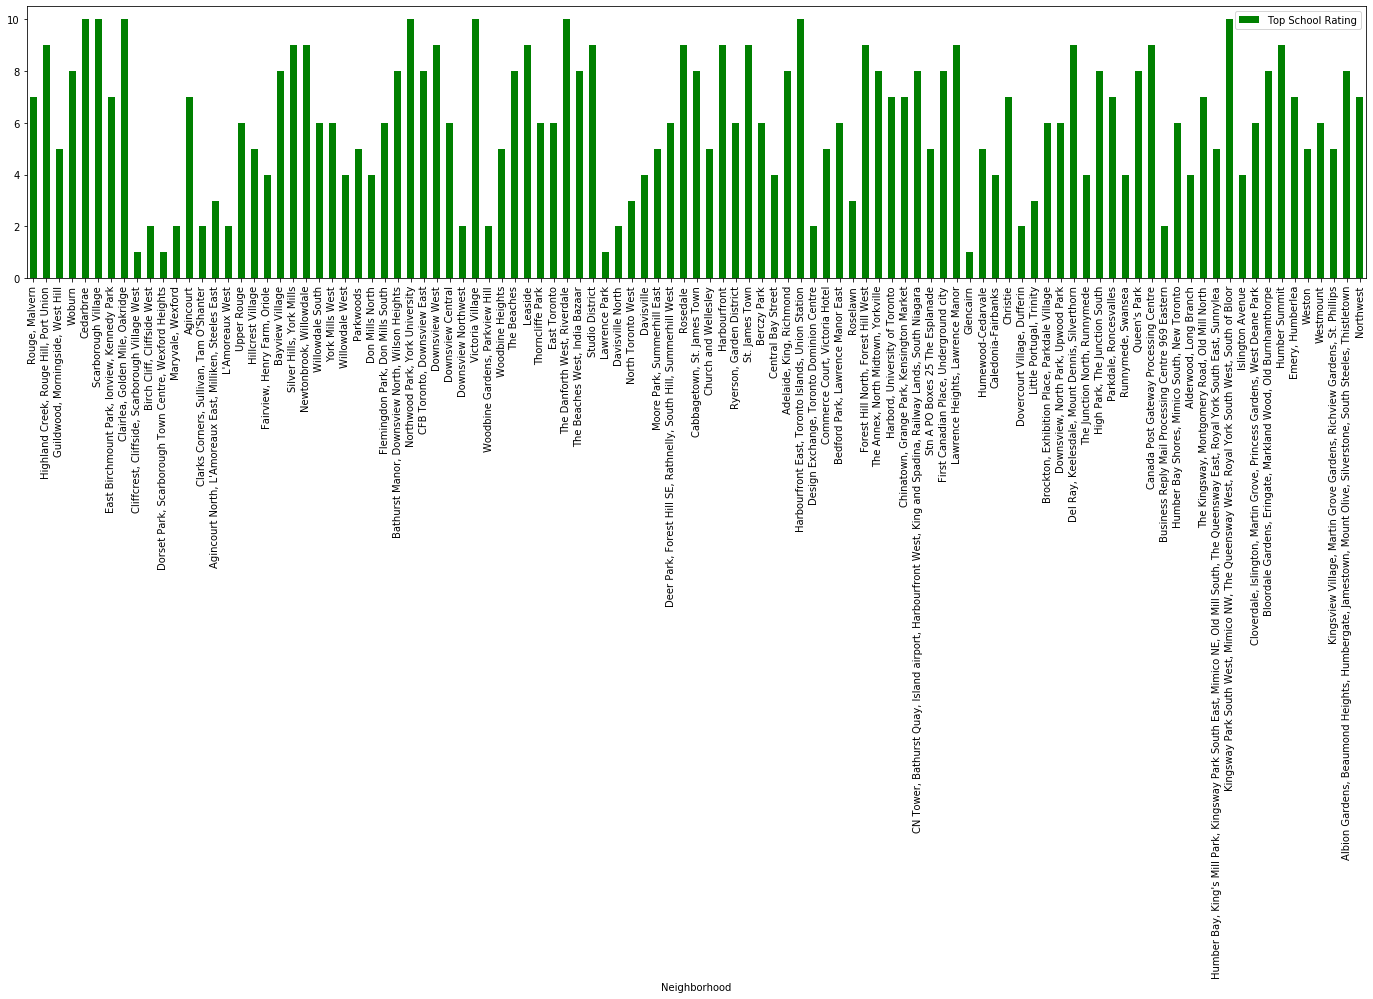

In [160]:
dt_school_ratings.plot(kind='bar',figsize=(24,5),color='green',alpha=1.0);